# Домашняя работа 8. Деревья решений. (32 балла)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #8: Name Surname`. Если тема будет неправильная, то задание не будет проверено.
6. Дедлайн: 18.12.2017 01:00 OMSK
7. После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

Рассылка решений: 25.12.2017 17:00 OMSK
После рассылки задания почти совсем не имеют веса.

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиции деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'../../data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('data/winequality-red.csv.gz', sep=';')
X, y = data.drop('quality', axis=1), data.quality

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


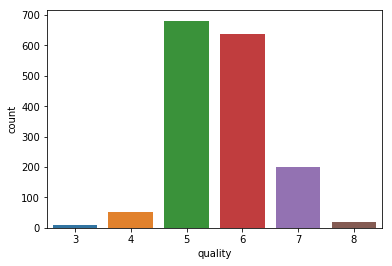

In [3]:
sns.countplot(data.quality, data=data)

Гляда по countplot, можно понять, что выборка несбалансирована по классам.

In [4]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [5]:
y.head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier 
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов. 

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [6]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

np.random.seed(seed=42)

##### Обучение KNeighborsClassifier с 10 соседями

In [7]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

kNN = KNeighborsClassifier(n_neighbors=10, n_jobs=4)
%time kNN.fit(X, y)

cross_val_score(kNN, X, y, scoring='accuracy', cv=kf, n_jobs=4).mean()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.27 ms


0.51221982758620688

##### Обучение KNeighborsClassifier с 10 соседями и масштабированием StandartScaler 

In [8]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X, y)

kNN_scaled = KNeighborsClassifier(n_neighbors=10, n_jobs=4)
%time kNN_scaled.fit(X_scaled, y)

cross_val_score(kNN_scaled, X_scaled, y, scoring='accuracy', cv=kf, n_jobs=4).mean()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.54 ms


0.57975313479623825

##### Обучение RidgeClassifier

In [9]:
ridge_clf = RidgeClassifier(random_state=42)
%time ridge_clf.fit(X, y)

cross_val_score(ridge_clf, X, y, scoring='accuracy', cv=kf, n_jobs=4).mean()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.53 ms


0.58353840125391854

##### Обучение DecisionTreeClassifier

In [10]:
dt_clf = DecisionTreeClassifier(random_state=42)
%time dt_clf.fit(X, y)

cross_val_score(dt_clf, X, y, scoring='accuracy', cv=kf, n_jobs=4).mean()

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 22.1 ms


0.61852076802507827

##### Обучение BaggingClassifier c 100 деревьев

In [11]:
bag_clf = BaggingClassifier(n_estimators=100, n_jobs=4, random_state=42)
%time bag_clf.fit(X, y)

cross_val_score(bag_clf, X, y, scoring='accuracy', cv=kf, n_jobs=1).mean()

CPU times: user 172 ms, sys: 52 ms, total: 224 ms
Wall time: 883 ms


0.69546042319749213

##### Обучение BaggingClassifier c 100 деревьев,  каждое дерево обучается только по половине случайно выбранных признаков

In [12]:
bag_clf = BaggingClassifier(n_estimators=100, max_features=.5, n_jobs=4, random_state=42)
%time bag_clf.fit(X, y)

cross_val_score(bag_clf, X, y, scoring='accuracy', cv=kf, n_jobs=1).mean()

CPU times: user 176 ms, sys: 76 ms, total: 252 ms
Wall time: 697 ms


0.69921630094043885

##### Обучение RandomForestClassifier с 100 деревьев

In [13]:
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=42)
%time rf_clf.fit(X, y)

cross_val_score(rf_clf, X, y, scoring='accuracy', cv=kf, n_jobs=1).mean()

CPU times: user 936 ms, sys: 64 ms, total: 1 s
Wall time: 609 ms


0.70109130094043892

### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без
- почему масштабирование не важно для деревьев решений
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??

1. Числовые признаки разного масштаба дают разный по величине вклад во время обучения. Подсчет расстояния между объектами очень зависит от значений координат этих объектов. StandardScaler нормирует признаки таким образом, что среднее и отклонение становятся равны единице. Таким образом нормируются и покоординатные разности для каждой пары объектов, что является важным, т.к. метрика Минковского учитыват эти самые покоординатные разности.

2. Критерий выбора наиболее информативного признака позволяет учесть разный вклад, которые дают признаки разного масштаба на данный момент. Таким образом деревья учитывают различие в масштабе.

3. Насколько я понимаю, уменьшение доли признаков, используемых для обучения, позволяет избегать переобучения дерева. Таким образом, каждое из деревьев в бэггинге отвечало только за объекты, из подходящей для данного дерева подвыборки.

4. У первой в списке модели. Видимо из-за того, что признаки не были масштабированы, её score оказался очень низким сравнительно остальных моделей  (ранее мы выяснили, что в алгоритмах, использующих метрику, масштаб координат имеет большое значение) .

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятсья делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

In [14]:
from sklearn.datasets import load_digits
dig_X, dig_y = load_digits(return_X_y=True)

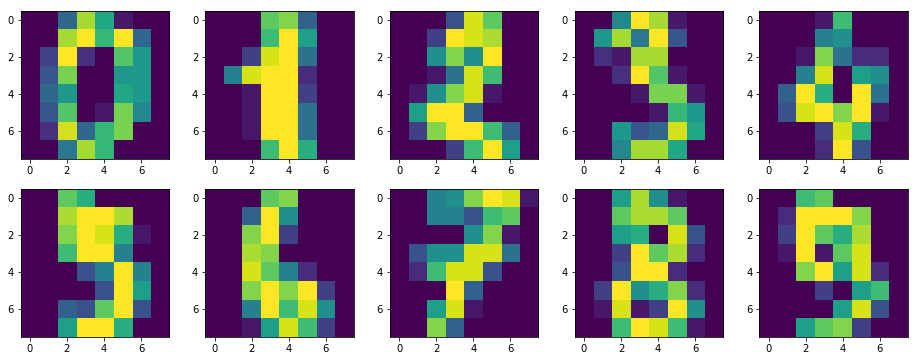

In [15]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(dig_X[i,:].reshape([8,8]))

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [16]:
clfs = [
    ('Decision tree (default parameters)', DecisionTreeClassifier(random_state=42)),
    ('Bagging clf (100 estimators)', BaggingClassifier(n_estimators=100, n_jobs=4, random_state=42)),
    ('Bagging clf (100 estimators, max_features=sqrt(N))', 
         BaggingClassifier(n_estimators=100, max_features=int(np.sqrt(len(dig_X[0]))), n_jobs=4, random_state=42)),
    ('Bagging clf (100 estimators, max_samples=sqrt(N))', 
         BaggingClassifier(base_estimator=DecisionTreeClassifier(
             random_state=42, max_features=int(np.sqrt(len(dig_X[0])))
         ), n_estimators=100, n_jobs=4, random_state=42)),
    ('Random forest (100 estimators)', RandomForestClassifier(n_estimators=100, random_state=42))
]

In [17]:
for c in clfs:
    print(c[0], ':')
    %time c[1].fit(dig_X, dig_y)
    print('Score:', cross_val_score(c[1], dig_X, dig_y, scoring='accuracy', cv=10, n_jobs=1).mean(), '\n')

Decision tree (default parameters) :
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 41 ms
Score: 0.837085080214 

Bagging clf (100 estimators) :
CPU times: user 208 ms, sys: 64 ms, total: 272 ms
Wall time: 1.52 s
Score: 0.926622379912 

Bagging clf (100 estimators, max_features=sqrt(N)) :
CPU times: user 200 ms, sys: 96 ms, total: 296 ms
Wall time: 714 ms
Score: 0.931169233525 

Bagging clf (100 estimators, max_samples=sqrt(N)) :
CPU times: user 176 ms, sys: 92 ms, total: 268 ms
Wall time: 813 ms
Score: 0.953332102247 

Random forest (100 estimators) :
CPU times: user 772 ms, sys: 92 ms, total: 864 ms
Wall time: 872 ms
Score: 0.953310668872 



### 2.3 В чём разница? (3 балла)

Ответье на вопрос: 

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?

![](https://i.ytimg.com/vi/_5GWMIAHc08/hqdefault.jpg)

##### Ответ:
Во втором случае, в отличие от первого, обучение каждого из деревьев происходит более разнообразными способами. Значимость признаков в разбиении выборки варьируется от дерева к дереву.

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

In [18]:
n_estimators = [1,5,10,15,50,100,150,200,300]
scores_est = []

for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=n, n_jobs=4, random_state=42)
    print(n, 'trees')
    %time clf.fit(dig_X, dig_y)
    score = cross_val_score(clf, dig_X, dig_y, scoring='accuracy', cv=10, n_jobs=4).mean()
    print('Score:', score)
    print()
    
    scores_est.append(score)

1 trees
CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 108 ms
Score: 0.761635733552

5 trees
CPU times: user 60 ms, sys: 4 ms, total: 64 ms
Wall time: 120 ms
Score: 0.883702869674

10 trees
CPU times: user 100 ms, sys: 4 ms, total: 104 ms
Wall time: 132 ms
Score: 0.927202121785

15 trees
CPU times: user 156 ms, sys: 12 ms, total: 168 ms
Wall time: 156 ms
Score: 0.941717861426

50 trees
CPU times: user 492 ms, sys: 24 ms, total: 516 ms
Wall time: 351 ms
Score: 0.955011386465

100 trees
CPU times: user 956 ms, sys: 48 ms, total: 1 s
Wall time: 574 ms
Score: 0.953310668872

150 trees
CPU times: user 1.52 s, sys: 72 ms, total: 1.59 s
Wall time: 1e+03 ms
Score: 0.948331555706

200 trees
CPU times: user 1.88 s, sys: 116 ms, total: 2 s
Wall time: 1.26 s
Score: 0.949973868701

300 trees
CPU times: user 2.88 s, sys: 128 ms, total: 3.01 s
Wall time: 1.73 s
Score: 0.951622990901



Optimal quantity of estimators: 50


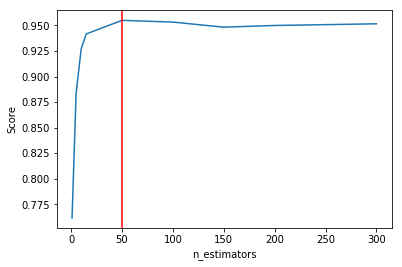

In [19]:
opt = np.argmax(scores_est)

plt.plot(n_estimators, scores_est)
plt.axvline(n_estimators[opt], color='r')
plt.xlabel('n_estimators')
plt.ylabel('Score')

print('Optimal quantity of estimators:', n_estimators[opt])

### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

In [20]:
n_features_max = np.append([1], range(4, 65, 4))
scores_feat = []

for n in n_features_max:
    clf = RandomForestClassifier(n_estimators=100, max_features=n, n_jobs=4, random_state=42)
    print('n_features_max:', n)
    %time clf.fit(dig_X, dig_y)
    score = cross_val_score(clf, dig_X, dig_y, scoring='accuracy', cv=10, n_jobs=4).mean()
    print('Score:', score)
    print()
    
    scores_feat.append(score)

n_features_max: 1
CPU times: user 744 ms, sys: 52 ms, total: 796 ms
Wall time: 618 ms
Score: 0.951667794048

n_features_max: 4
CPU times: user 852 ms, sys: 32 ms, total: 884 ms
Wall time: 710 ms
Score: 0.960037515214

n_features_max: 8
CPU times: user 996 ms, sys: 32 ms, total: 1.03 s
Wall time: 615 ms
Score: 0.953310668872

n_features_max: 12
CPU times: user 1.12 s, sys: 52 ms, total: 1.17 s
Wall time: 614 ms
Score: 0.951091013339

n_features_max: 16
CPU times: user 1.27 s, sys: 40 ms, total: 1.31 s
Wall time: 691 ms
Score: 0.948352750518

n_features_max: 20
CPU times: user 1.38 s, sys: 52 ms, total: 1.44 s
Wall time: 667 ms
Score: 0.946065352762

n_features_max: 24
CPU times: user 1.56 s, sys: 44 ms, total: 1.6 s
Wall time: 679 ms
Score: 0.94887199695

n_features_max: 28
CPU times: user 1.72 s, sys: 40 ms, total: 1.76 s
Wall time: 765 ms
Score: 0.940487146243

n_features_max: 32
CPU times: user 1.87 s, sys: 36 ms, total: 1.91 s
Wall time: 769 ms
Score: 0.946022775544

n_features_max:

Optimal max_features value: 4


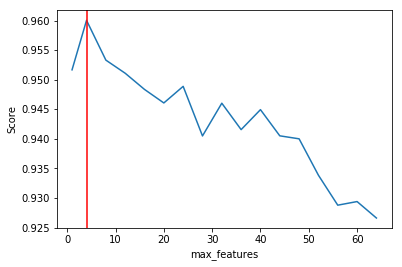

In [21]:
opt = np.argmax(scores_feat)

plt.plot(n_features_max, scores_feat)
plt.axvline(n_features_max[opt], color='r')
plt.xlabel('max_features')
plt.ylabel('Score')

print('Optimal max_features value:', n_features_max[opt])

### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?

1. Судя по графику, это не имеет большого смысла. Т.е. примерно после 50 деревьев score начинает выравниваться и выходит на плато. Нет смысла тратить время на вычисления модели для большего числа деревьев, достаточно найти оптимум так, как мы это сделали в нашей задаче.

2. Судя по графику оно имеет некоторый оптимум, после которого падает.

3. Большое число max_features ведёт к переобучению деревьев. Слишком малого числа может просто не хватить для хорошего предсказания. Поэтому существует некая точка максимума.

4. С увеличением максимальной глубины score, в большинстве случаев, возрастая стремится к ассимптоте (см. ниже). Увеличение максимальной глубины дерева позволяет справляться с переобучением, т.е. в некотором смысле увеличение максимальной глубины является способом регуляризации модели.

##### Зависимость качества от максимальной глубины дерева:

In [22]:
max_depths = np.append([1], range(5, 40, 5))
scores_depth = []

for d in max_depths:
    clf = RandomForestClassifier(n_estimators=100, max_depth=d, n_jobs=4, random_state=42)
    print('max_depth =', d)
    %time clf.fit(dig_X, dig_y)
    score = cross_val_score(clf, dig_X, dig_y, scoring='accuracy', cv=10, n_jobs=4).mean()
    print('Score:', score)
    print()
    
    scores_depth.append(score)

max_depth = 1
CPU times: user 580 ms, sys: 16 ms, total: 596 ms
Wall time: 603 ms
Score: 0.6872222815

max_depth = 5
CPU times: user 792 ms, sys: 52 ms, total: 844 ms
Wall time: 666 ms
Score: 0.912057680194

max_depth = 10
CPU times: user 944 ms, sys: 28 ms, total: 972 ms
Wall time: 576 ms
Score: 0.948862911477

max_depth = 15
CPU times: user 952 ms, sys: 56 ms, total: 1.01 s
Wall time: 578 ms
Score: 0.953304761326

max_depth = 20
CPU times: user 940 ms, sys: 48 ms, total: 988 ms
Wall time: 568 ms
Score: 0.953310668872

max_depth = 25
CPU times: user 940 ms, sys: 56 ms, total: 996 ms
Wall time: 576 ms
Score: 0.953310668872

max_depth = 30
CPU times: user 944 ms, sys: 52 ms, total: 996 ms
Wall time: 579 ms
Score: 0.953310668872

max_depth = 35
CPU times: user 1.02 s, sys: 40 ms, total: 1.06 s
Wall time: 768 ms
Score: 0.953310668872



Optimal max_depth value: 20


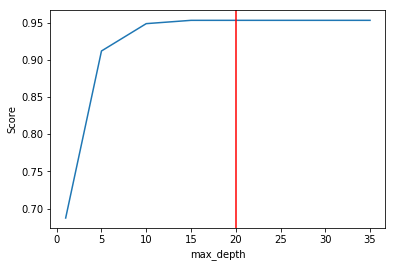

In [23]:
opt = np.argmax(scores_depth)

plt.plot(max_depths, scores_depth)
plt.axvline(max_depths[opt], color='r')
plt.xlabel('max_depth')
plt.ylabel('Score')

print('Optimal max_depth value:', max_depths[opt])

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)